In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
import glob

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [2]:
coco = COCO("pascal_train.json") # load training annotations

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


In [3]:
coco.cats # check the category

{1: {'supercategory': 'aeroplane', 'name': 'aeroplane', 'id': 1},
 2: {'supercategory': 'bicycle', 'name': 'bicycle', 'id': 2},
 3: {'supercategory': 'bird', 'name': 'bird', 'id': 3},
 4: {'supercategory': 'boat', 'name': 'boat', 'id': 4},
 5: {'supercategory': 'bottle', 'name': 'bottle', 'id': 5},
 6: {'supercategory': 'bus', 'name': 'bus', 'id': 6},
 7: {'supercategory': 'car', 'name': 'car', 'id': 7},
 8: {'supercategory': 'cat', 'name': 'cat', 'id': 8},
 9: {'supercategory': 'chair', 'name': 'chair', 'id': 9},
 10: {'supercategory': 'cow', 'name': 'cow', 'id': 10},
 11: {'supercategory': 'diningtable', 'name': 'diningtable', 'id': 11},
 12: {'supercategory': 'dog', 'name': 'dog', 'id': 12},
 13: {'supercategory': 'horse', 'name': 'horse', 'id': 13},
 14: {'supercategory': 'motorbike', 'name': 'motorbike', 'id': 14},
 15: {'supercategory': 'person', 'name': 'person', 'id': 15},
 16: {'supercategory': 'pottedplant', 'name': 'pottedplant', 'id': 16},
 17: {'supercategory': 'sheep', 'n

In [6]:
# The keys in coco.imgs (dictionary) can be used to track each image
print(list(coco.imgs.keys())[:20])
print(coco.imgs[736])

[736, 1392, 890, 1178, 1065, 265, 410, 806, 982, 272, 15, 766, 734, 227, 649, 373, 222, 351, 765, 425]
{'file_name': '2009_001816.jpg', 'id': 736, 'height': 375, 'width': 500}


In [7]:
imgIds = 5 # Use the key above to retrieve information of the image
img_info = coco.loadImgs(ids=imgIds)
print(img_info)

[{'file_name': '2007_000129.jpg', 'id': 5, 'height': 500, 'width': 334}]


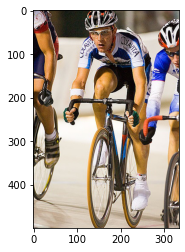

In [8]:
image = cv2.imread(img_info[0]['file_name'])[:,:,::-1] # In your implementation, you should find this image in **train_images/** folders
plt.imshow(image)

In [9]:
# Use the imgIds to find all instance ids of the image
annids = coco.getAnnIds(imgIds=imgIds)
print(annids)

[9, 10, 11, 12, 13, 14]


In [10]:
anns = coco.loadAnns(annids)
print("Number of instances: ", len(annids))

Number of instances:  6


In [11]:
instance_id = 0
print(anns[instance_id].keys()) # check the information of the first instance of the image

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])


In [12]:
print("Polygons of segmenatation:      ", anns[instance_id]['segmentation'][0][:18])
print("Image id of this instance:      ", anns[instance_id]['image_id'])
print("Bounding box of this instance:  ", anns[instance_id]['bbox'])
print("Category_id:                    ", anns[instance_id]['category_id'])

Polygons of segmenatation:       [90, 257, 88, 259, 89, 260, 89, 261, 91, 263, 92, 263, 94, 261, 93, 260, 93, 259]
Image id of this instance:       5
Bounding box of this instance:   [79, 203, 173, 297]
Category_id:                     2


## Visualization

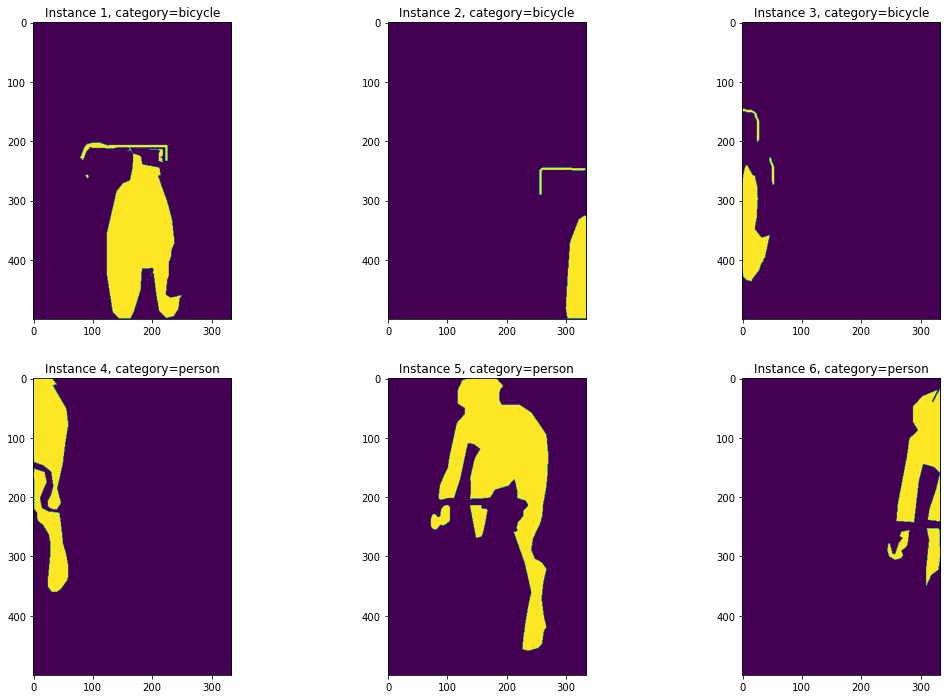

In [13]:
plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
for i in range(len(annids)):
    mask = coco.annToMask(anns[i])
    cate = anns[i]['category_id']
    plt.subplot(2, 3, i+1)
    plt.title("Instance {}, category={}".format(i+1, coco.cats[cate]['name']))
    plt.imshow(mask)

## Prepare submission file
The format of submission.json file is same as the officail COCO evaluation format. Therefore, we can evaluate your results with the official evaluation code. Please see [here](http://cocodataset.org/#format-results) for more details.

In [14]:
cocoGt = COCO("test.json")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [15]:
from utils import binary_mask_to_rle

In [16]:
coco_dt = []

for imgid in cocoGt.imgs:
    image = cv2.imread("test_images/" + coco.loadImgs(ids=imgid)[0]['file_name'])[:,:,::-1] # load image
    masks, categories, scores = model.predict(image) # run inference of your model
    n_instances = len(score)    if len(categories) > 0: # If any objects are detected in this image
        for i in range(n_instances): # Loop all instances
            # save information of the instance in a dictionary then append on coco_dt list
            pred = {}
            pred['image_id'] = imgid # this imgid must be same as the key of test.json
            pred['category_id'] = int(categories[i])
            pred['segmentation'] = binary_mask_to_rle(masks[:,:,i]) # save binary mask to RLE, e.g. 512x512 -> rle
            pred['score'] = float(scores[i])
            coco_dt.append(pred)

SyntaxError: invalid syntax (<ipython-input-16-336bd9a5ed69>, line 6)

In [ ]:
with open("submission.json", "w") as f:
    json.dump(coco_dt, f)

### To validate your json file, you can predict on your training data and use code below to evaluate

In [20]:
cocoGt = COCO("pascal_train.json")

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


generate submission file of training data
```python
coco_dt_train = []
for img in train_images:
    ...
    
with open("submission_train.json", "w") as f:
    json.dump(coco_dt_train, f)
```

In [ ]:
cocoDt = cocoGt.loadRes("submission_train.json")

cocoEval = COCOeval(cocoGt, cocoDt, 'segm')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()